In [22]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
import warnings

In [23]:
import SEDR

In [24]:
random_seed = 2023
SEDR.fix_seed(random_seed)

In [25]:
# gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# path
data_root = Path('../data/DLPFC')

# sample name
sample_name = '151674'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7

In [26]:
adata = sc.read_visium(data_root / sample_name)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [27]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
graph_dict = SEDR.graph_construction(adata, 12)
print(graph_dict)

{'adj_norm': tensor(indices=tensor([[   0,    0,    0,  ..., 3672, 3672, 3672],
                       [   0,  397,  486,  ..., 3434, 3595, 3672]]),
       values=tensor([0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769]),
       size=(3673, 3673), nnz=48959, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 3672, 3672, 3672],
                       [   0,  397,  486,  ..., 3434, 3595, 3672]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(3673, 3673), nnz=48959, dtype=torch.float64,
       layout=torch.sparse_coo), 'norm_value': 0.5018211244333978}


In [29]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

  0%|                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/SEDR-1.0.0-py3.10.egg/SEDR/SEDR_model.py:105: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  total_idx = torch.range(0, self.cell_num-1, dtype=torch.float32).to(self.device)
  0%|                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/SEDR-1.0.0-py3.10.egg/SEDR/SEDR_model.py:275: UserWarning: To copy construct

In [30]:
def mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR', random_seed=2023):
    np.random.seed(random_seed)
    modelNames = 'EEE'
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[use_rep]), n_clusters, modelNames)
    mclust_res = np.array(res[-2])-1

    adata.obs[key_added] = mclust_res
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [31]:
adata = mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')

fitting ...
  |======================================================================| 100%


/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


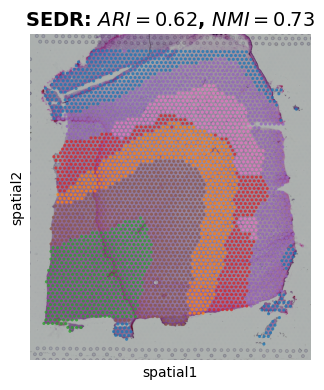

In [32]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['SEDR'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['layer_guess'], sub_adata.obs['SEDR'])
fig, ax = plt.subplots(1,1,figsize=(4, 4), facecolor='none')
sc.pl.spatial(adata, color='SEDR', ax=ax, show=False,legend_loc=None, alpha=0.8, color_map='viridis' )
# 设置标题，优化格式
ax.set_title(r'SEDR: $\mathit{ARI}=%.2f$, $\mathit{NMI}=%.2f$' % (ARI, NMI), fontsize=14, fontweight='bold')
# 移除坐标轴刻度
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)  # 去掉边框

# 调整布局
plt.tight_layout(pad=0.5)  
axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_dir = ('./SEDR_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"SEDR_{sample_name}_ARI.svg")
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

In [33]:
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"{sample_name}.h5ad")
adata.write_h5ad(output_path)

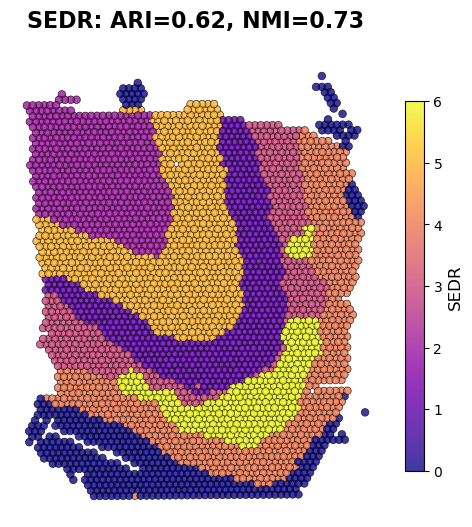

In [21]:
import matplotlib.pyplot as plt

# 获取空间坐标
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]
colors = adata.obs['SEDR']  # 颜色基于 SEDR 值

# 创建图形
fig, ax = plt.subplots(figsize=(6, 6))

# 绘制散点图
scatter = ax.scatter(
    x, y,
    c=colors,
    cmap='plasma',  # 使用更美观的颜色映射
    s=30,  # 点的大小
    alpha=0.8,
    edgecolor='k',  # 点的边框颜色
    linewidth=0.5  # 点的边框宽度
)

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('SEDR', fontsize=12)

# 设置标题
ax.set_title(
    f'SEDR: ARI={ARI:.2f}, NMI={NMI:.2f}',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# 移除坐标轴
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
plt.show()

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_174088/1079809694.py:14: RuntimeWarning: Mean of empty slice.
  x_mean, y_mean = cluster

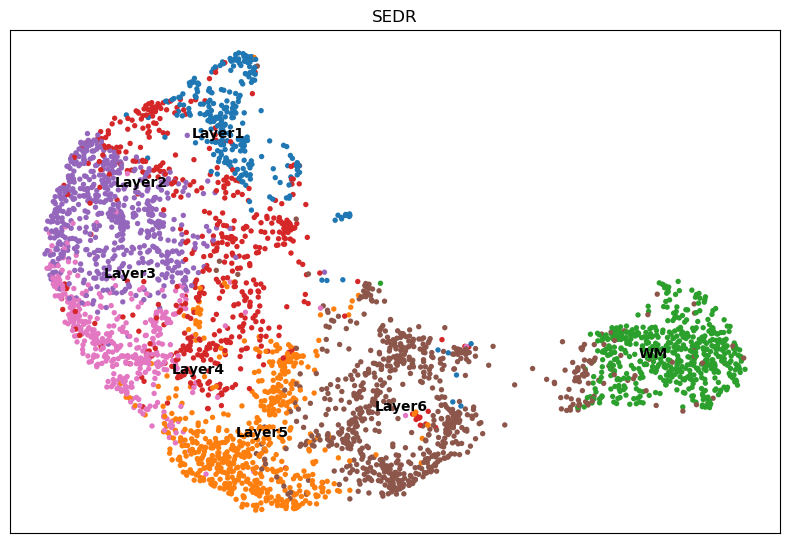

In [12]:
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata, min_dist=0.2, spread=0.6)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color='SEDR', ax=axes, show=False,size=60,legend_loc=None)

# 设置标题
axes.set_title('SEDR')
axes.set_aspect(1)

for cluster in adata.obs['layer_guess'].unique():
    # 计算每个类别的 UMAP 中心点
    cluster_points = adata[adata.obs['layer_guess'] == cluster].obsm['X_umap']
    x_mean, y_mean = cluster_points[:, 0].mean(), cluster_points[:, 1].mean()

    # 在中心点处添加标签
    axes.text(
        x=x_mean,  # X 坐标
        y=y_mean,  # Y 坐标
        s=cluster,  # 标签内容
        fontsize=10,
        ha='center',  # 水平对齐
        va='center',  # 垂直对齐
        color='black',  # 标签颜色
        fontweight='bold'  # 标签字体加粗
    )

axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_path = os.path.join('./clustering_results', f"SEDR_{sample_name}.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()